# Extended Analysis: Wildfire Smoke Impact and Stock Performance
This notebook extends the initial analysis of smoke impact on Peoria, AZ, by incorporating stock prices of companies operating in the area. The goal is to evaluate and predict economic impacts related to wildfire smoke using advanced modeling techniques.


## Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV



## Obtaining the Stock Data

Here, we retrieve monthly stock data for selected companies near Peoria, AZ, using the [Alpha Vantage API](https://www.alphavantage.co/). The data includes historical closing prices and is saved for further analysis. This step ensures we have accurate financial data to study the relationship between smoke impact and stock performance.

For obtaining the Alpha Vantage API key:

- Visit [Alpha Vantage](https://www.alphavantage.co/) and sign up for an account.
- Navigate to the API key section in your profile to generate a key.
- Replace the placeholder api_key = "YOUR_API_KEY" in the code with your actual API key.
- Ensure you adhere to rate limits (5 requests per minute for the free tier).

In [21]:
from alpha_vantage.timeseries import TimeSeries

In [ ]:
# REPLACE With Your Alpha Vantage API Key
api_key = "9VAEN3LYZ9T9KB0K"

# Initialize the TimeSeries object
ts = TimeSeries(key=api_key, output_format='pandas')

# List of tickers for the companies you're interested in
tickers = ['ON', 'AMKR', 'FSLR', 'KNX', 'WAL', 'CVNA', 'SFM', 'NSIT', 'AVT']

# Dictionary to store the data for each ticker
stock_data = {}

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        # Get monthly stock data
        data, meta_data = ts.get_monthly(symbol=ticker)
        stock_data[ticker] = data
        print(f"Data for {ticker} fetched successfully.")
        
        # Wait to avoid hitting the API rate limit (5 API calls per minute for free tier)
        time.sleep(12)
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# Combine all stock data into a single DataFrame and save as a CSV
if stock_data:
    combined_data = pd.concat(stock_data, axis=0)
    combined_data.to_csv("maricopa_county_stocks_monthly.csv")
    print("All data saved to 'maricopa_county_stocks_monthly.csv'")
else:
    print("No data fetched.")


In [ ]:
tickers = ['SPY']

sp500_data = {}

try:
    print("Fetching S&P 500 data...")
    sp500_data, _ = ts.get_monthly(symbol="SPY")
    sp500_data.reset_index(inplace=True)
    sp500_data.rename(columns={"date": "Date", "4. close": "SP500_Close"}, inplace=True)
    sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])
    sp500_data["YearMonth"] = sp500_data["Date"].dt.to_period("M")
    print("S&P 500 data fetched successfully.")
except Exception as e:
    print(f"Failed to fetch S&P 500 data: {e}")
    sp500_data = pd.DataFrame()

sp500_data.to_csv("sp500_monthly.csv")


## Load Data

This section consolidates data from multiple sources, including wildfire smoke impact data (Part 1 of the analysis, found in the repository in the Jupyter Notebook called `common_analysis.ipynb`), stock prices, and S&P 500 index data. Each dataset is processed to ensure uniform formats, enabling seamless integration and analysis. The goal is to create a unified dataset for further exploration and modeling.

In [144]:
# Load smoke impact data
smoke_data = pd.read_csv("data/smoke_impact_peoria.csv")
smoke_data["YearMonth"] = pd.to_datetime(smoke_data["Year"], format="%Y").dt.to_period("M")

# Load stock data
stock_data = pd.read_csv("data/maricopa_county_stocks_monthly.csv", index_col=[0, 1])
stock_data.reset_index(inplace=True)
stock_data.rename(columns={"level_0": "Ticker", "level_1": "Date"}, inplace=True)
stock_data["date"] = pd.to_datetime(stock_data["date"])
stock_data["YearMonth"] = stock_data["date"].dt.to_period("M")

# Load S&P 500 data
sp500_data = pd.read_csv("data/sp500_monthly.csv")
sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])
sp500_data["YearMonth"] = sp500_data["Date"].dt.to_period("M")


## Preprocessing

The preprocessing step cleans and prepares the data for modeling. Stock data is aggregated monthly, and percent changes are calculated to measure performance trends. Adjusted stock changes are computed by accounting for market trends using the S&P 500 index as a baseline. This step ensures the data is ready for feature engineering and modeling.

In [145]:
# Aggregate stock data by month
stock_data = stock_data.groupby(["Ticker", "YearMonth"])["4. close"].mean().reset_index()
stock_data.rename(columns={"4. close": "Close"}, inplace=True)

In [146]:
# Merge stock data with smoke impact
merged_data = pd.merge(stock_data, smoke_data, on="YearMonth", how="inner")

# Merge with S&P 500 data
merged_data = pd.merge(
    merged_data, sp500_data[["YearMonth", "SP500_Close"]], on="YearMonth", how="left"
)


In [147]:
# Calculate percent changes
merged_data["Stock Percent Change"] = merged_data.groupby("Ticker")["Close"].pct_change()
merged_data["SP500 Percent Change"] = merged_data["SP500_Close"].pct_change()

Adjust stock percent change for market trends

In [148]:
# Adjust stock percent change for market trends
merged_data["Adjusted Stock Change"] = (
    merged_data["Stock Percent Change"] - merged_data["SP500 Percent Change"]
)
merged_data.dropna(subset=["Adjusted Stock Change", "Smoke Impact"], inplace=True)

Try Moving averages as well

In [149]:
# Calculate moving averages for detrending
window = 12  # 12-month moving average
merged_data["Stock MA"] = merged_data.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window).mean())
merged_data["SP500 MA"] = merged_data["SP500_Close"].rolling(window).mean()

# Calculate percent changes based on moving averages
merged_data["Stock MA Percent Change"] = merged_data.groupby("Ticker")["Stock MA"].pct_change()
merged_data["SP500 MA Percent Change"] = merged_data["SP500 MA"].pct_change()

# Adjust stock percent change for market trends using moving averages
merged_data["Adjusted Stock Change MA"] = (
    merged_data["Stock MA Percent Change"] - merged_data["SP500 MA Percent Change"]
)

# merged_data.dropna(subset=["Adjusted Stock Change MA", "Smoke Impact"], inplace=True)


C:\Users\amitp\AppData\Local\Temp\ipykernel_14164\3153981913.py:7: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data["Stock MA Percent Change"] = merged_data.groupby("Ticker")["Stock MA"].pct_change()


In [107]:
merged_data[merged_data['Ticker'] == 'ON']

,Ticker,YearMonth,Close,Year,Smoke Impact,SP500_Close,Stock Percent Change,SP500 Percent Change,Adjusted Stock Change,Stock MA,SP500 MA,Stock MA Percent Change,SP500 MA Percent Change,Adjusted Stock Change MA
108,ON,2002-01,3.100,2002,77.960061,113.18,-0.579661,-0.173989,-0.405672,NaN,213.782500,NaN,0.002262,NaN
109,ON,2003-01,1.280,2003,35.487014,86.06,-0.587097,-0.239618,-0.347478,NaN,210.230833,NaN,-0.016613,NaN
110,ON,2004-01,7.000,2004,79.620726,113.48,4.468750,0.318615,4.150135,NaN,208.744167,NaN,-0.007072,NaN
111,ON,2005-01,3.660,2005,1081.807683,118.16,-0.477143,0.041241,-0.518384,NaN,206.115833,NaN,-0.012591,NaN
112,ON,2006-01,7.510,2006,52.620204,127.50,1.051913,0.079045,0.972867,NaN,201.892500,NaN,-0.020490,NaN
113,ON,2007-01,8.360,2007,32.822938,143.75,0.113182,0.127451,-0.014269,NaN,197.250833,NaN,-0.022991,NaN
114,ON,2008-01,6.480,2008,42.588522,137.37,-0.224880,-0.044383,-0.180498,NaN,192.555000,NaN,-0.023806,NaN
115,ON,2009-01,4.170,2009,38.129124,82.83,-0.356481,-0.397030,0.040548,NaN,180.496667,NaN,-0.062623,NaN
116,ON,2010-01,7.210,2010,25.191242,107.39,0.729017,0.296511,0.432506,NaN,165.954167,NaN,-0.080569,NaN
117,ON,2011-01,11.050,2011,63.309093,128.68,0.532594,0.198249,0.334344,NaN,154.183333,NaN,-0.070928,NaN


### Normalized Stock Closing Prices Over Time

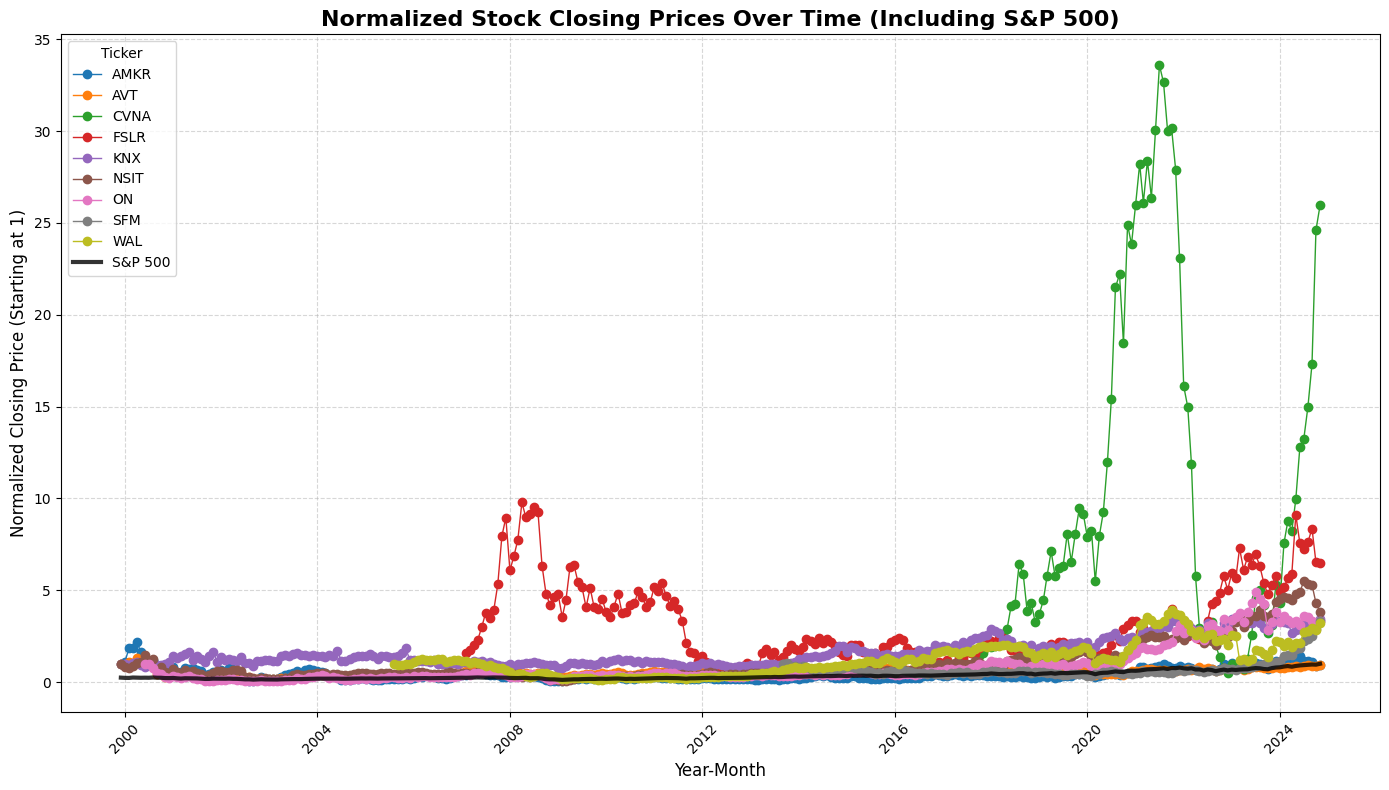

In [108]:
plt.figure(figsize=(14, 8))

# Normalize individual stock prices
for ticker in stock_data["Ticker"].unique():
    subset = stock_data[stock_data["Ticker"] == ticker]
    subset = subset.copy()  # Avoid SettingWithCopyWarning
    subset["Normalized Close"] = subset["Close"] / subset["Close"].iloc[0]  # Normalize to first value
    plt.plot(
        subset["YearMonth"].dt.to_timestamp(),
        subset["Normalized Close"],
        label=ticker,
        marker="o",
        linewidth=1
    )

# Normalize S&P 500 data
sp500_data["Normalized SP500_Close"] = sp500_data["SP500_Close"] / sp500_data["SP500_Close"].iloc[0]
plt.plot(
    sp500_data["YearMonth"].dt.to_timestamp(),
    sp500_data["Normalized SP500_Close"],
    label="S&P 500",
    color="black",
    linestyle="-",
    linewidth=3,
    alpha=0.8
)

# Enhance visualization
plt.title("Normalized Stock Closing Prices Over Time (Including S&P 500)", fontsize=16, weight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Normalized Closing Price (Starting at 1)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc="upper left", title="Ticker")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


This plot visualizes the normalized stock closing prices of various companies in Peoria, AZ, compared with the normalized S&P 500 index. Normalizing the data allows us to compare trends across different stocks and the market index, regardless of their initial price levels.

**Axes**:

- **X-axis**: Year-Month, indicating the time period of the data.
- **Y-axis**: Normalized closing prices, scaled to start at 1.

**How to Read**:

- Identify trends in individual stock performance compared to the broader market (S&P 500).
- Stocks significantly deviating from the S&P 500 line may indicate unique company-specific factors or sensitivity to external influences like wildfire smoke.
- Parallel trends suggest general market behavior, while diverging trends highlight specific variations.

**Underlying Data and Processing**:

- Historical closing prices are normalized by dividing each stock's closing price by its initial value in the dataset.
- S&P 500 index is similarly normalized for comparison.

### Detrended Stock Data Over Time

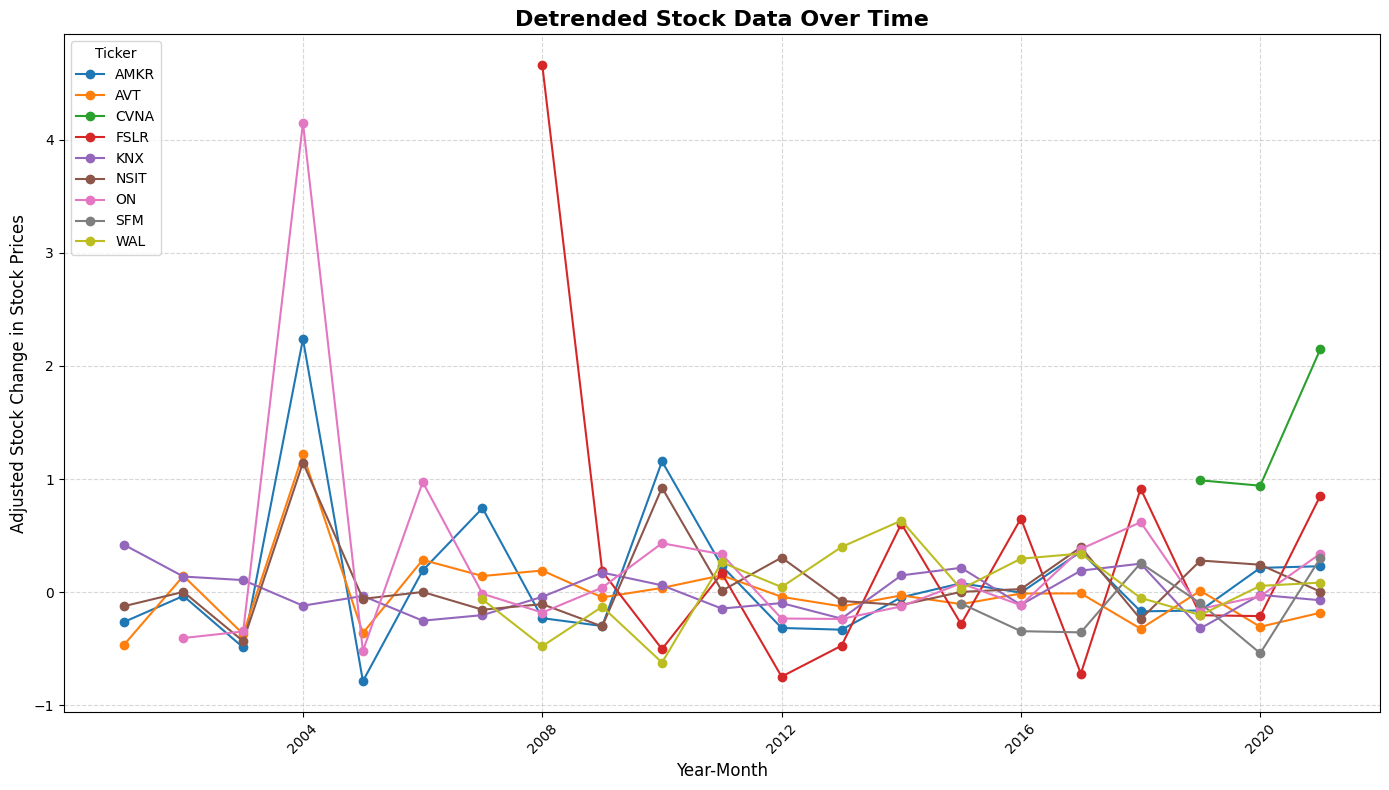

In [150]:
plt.figure(figsize=(14, 8))
for ticker in merged_data["Ticker"].unique():
    subset = merged_data[merged_data["Ticker"] == ticker]
    plt.plot(subset["YearMonth"].dt.to_timestamp(), subset["Adjusted Stock Change"], label=ticker, marker="o")

plt.title("Detrended Stock Data Over Time", fontsize=16, weight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Adjusted Stock Change in Stock Prices", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10, loc="upper left", title="Ticker")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

This plot highlights detrended adjusted stock changes, isolating individual company performance from overall market trends. Detrending helps focus on stock performance changes attributed to local factors, like smoke impact.

**Axes**:

- **X-axis**: Year-Month.
- **Y-axis**: Adjusted stock change (percent change after removing market influence).

**How to Read**:

- Fluctuations around zero indicate company-specific performance, independent of market trends.
- Consistent positive or negative adjusted stock changes can signal resilience or vulnerability to local conditions, like wildfire smoke exposure.

**Underlying Data and Processing**:

- Stock percent changes are adjusted by subtracting the S&P 500 percent change.
- Adjusted values emphasize deviations from market performance.

### Average Smoke Impact vs. Stock Performance

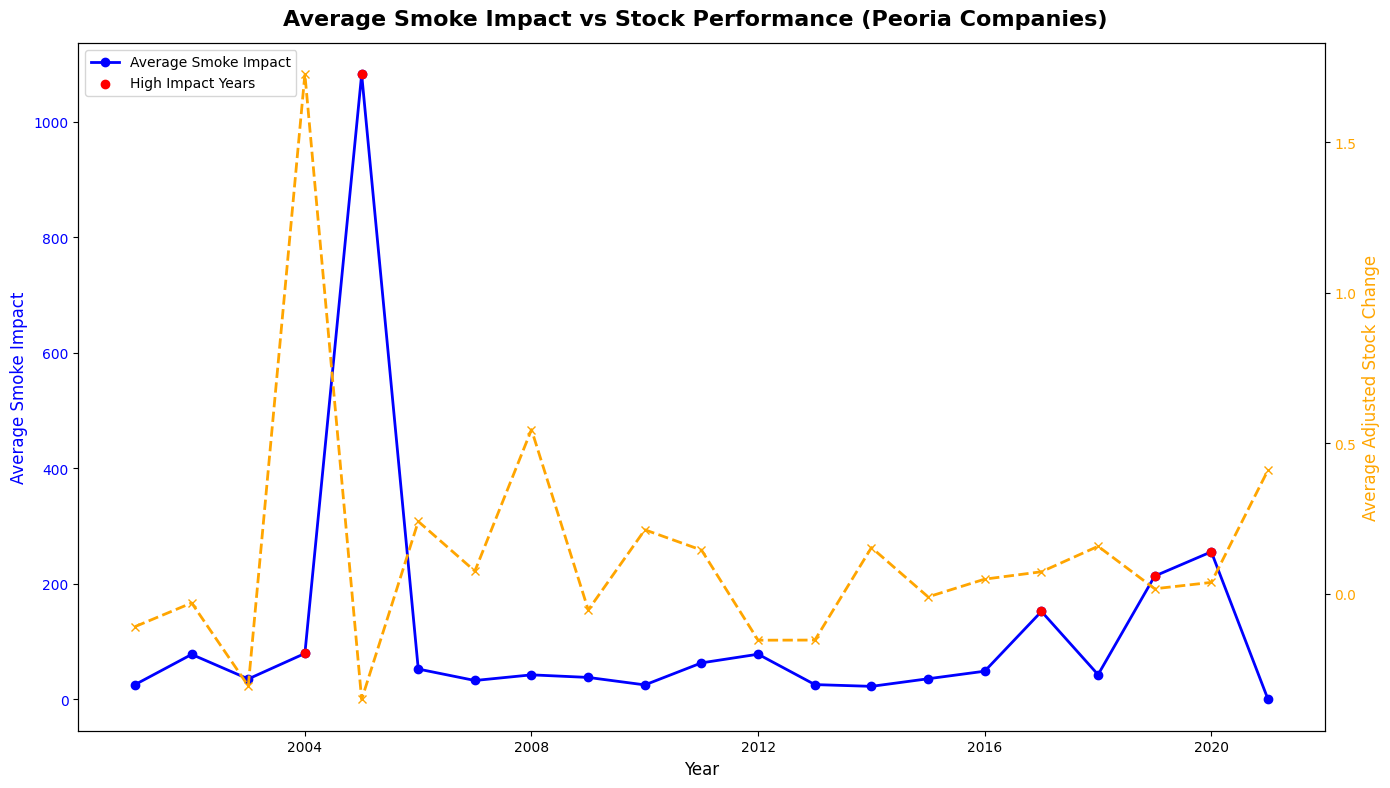

In [152]:
aggregated_data = merged_data.groupby("YearMonth")[["Smoke Impact", "Adjusted Stock Change"]].mean().reset_index()

# Step 10: Highlight Key Years with Dual Axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Smoke Impact
color = "blue"
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Average Smoke Impact", color=color, fontsize=12)
ax1.plot(aggregated_data["YearMonth"].dt.to_timestamp(), aggregated_data["Smoke Impact"], marker="o", color=color, label="Average Smoke Impact", linewidth=2)
ax1.tick_params(axis="y", labelcolor=color)

# Stock Performance
ax2 = ax1.twinx()
color = "orange"
ax2.set_ylabel("Average Adjusted Stock Change", color=color, fontsize=12)
ax2.plot(aggregated_data["YearMonth"].dt.to_timestamp(), aggregated_data["Adjusted Stock Change"], marker="x", color=color, label="Adjusted Stock Change", linewidth=2, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)

# Highlight years with high smoke impact
high_impact_years = aggregated_data[aggregated_data["Smoke Impact"] > aggregated_data["Smoke Impact"].quantile(0.75)]
ax1.scatter(high_impact_years["YearMonth"].dt.to_timestamp(), high_impact_years["Smoke Impact"], color="red", zorder=5, label="High Impact Years")

# Title and legend
fig.suptitle("Average Smoke Impact vs Stock Performance (Peoria Companies)", fontsize=16, weight="bold")
ax1.legend(loc="upper left")
fig.tight_layout()
plt.show()

This dual-axis plot compares the average smoke impact with adjusted stock performance over time, aiming to uncover correlations between wildfire smoke and economic performance.

**Axes**:

- **Primary Y-axis (left)**: Average Smoke Impact.
- **Secondary Y-axis (right)**: Average Adjusted Stock Change.
- **X-axis**: Year.

**How to Read**:

- Identify years with high smoke impact (marked as red scatter points) and assess corresponding adjusted stock changes.
- Periods with aligned spikes or dips in smoke impact and stock performance may suggest a direct relationship.

**Underlying Data and Processing**:

- Smoke impact values are aggregated yearly.
- Adjusted stock changes are averaged for all stocks.
- High smoke impact years are highlighted based on the top 25% quantile of impact data.

## Feature Engineering

In this step, lagged features are introduced to capture temporal dependencies, providing insights into how past values of smoke impact and adjusted stock changes affect future performance. The features are then standardized for compatibility with machine learning models, ensuring that all variables are on a similar scale.

In [113]:
# Lagged features for time series prediction
for lag in range(1, 4):
    merged_data[f"Smoke Impact Lag {lag}"] = merged_data["Smoke Impact"].shift(lag)
    merged_data[f"Adjusted Stock Change Lag {lag}"] = merged_data["Adjusted Stock Change MA"].shift(lag)

merged_data.dropna(inplace=True)

# Features and target
features = [
    "Smoke Impact", "Smoke Impact Lag 1", "Smoke Impact Lag 2", "Smoke Impact Lag 3",
    "Adjusted Stock Change Lag 1", "Adjusted Stock Change Lag 2"
]
target = "Adjusted Stock Change MA"

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data[features])
y = merged_data[target]


## Modeling

### Gradient Boosting Regression

A Gradient Boosting model is trained to predict adjusted stock changes based on engineered features. This section evaluates the model using metrics like Mean Squared Error (MSE) and R-squared, offering a baseline for comparing other approaches. Gradient Boosting is chosen for its ability to handle complex, nonlinear relationships.

In [114]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [116]:
# Evaluate the model
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Gradient Boosting Model - MSE: {mse:.4f}, R²: {r2:.4f}")

Gradient Boosting Model - MSE: 0.0014, R²: 0.4790


### LSTM Model

This section implements an LSTM (Long Short-Term Memory) neural network to capture sequential dependencies in the data. LSTM is particularly suitable for time-series data, where understanding the order of observations is critical. The model's performance is evaluated, and its predictions are compared to the Gradient Boosting model.

In [117]:
# Prepare data for LSTM
sequence_length = 5
X_lstm = []
y_lstm = []
for i in range(sequence_length, len(X)):
    X_lstm.append(X[i-sequence_length:i])
    y_lstm.append(y.iloc[i])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Train-test split
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [118]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/20


C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0026 - val_loss: 0.0025
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0017 - val_loss: 0.0014
Epo

In [119]:
# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Model - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
LSTM Model - MSE: 0.0013, R²: -1.8486


## Visualization
Predictions from both models are visualized to compare actual versus predicted values. These plots help assess the models' effectiveness in capturing the relationship between smoke impact and stock performance and provide a visual summary of their accuracy.

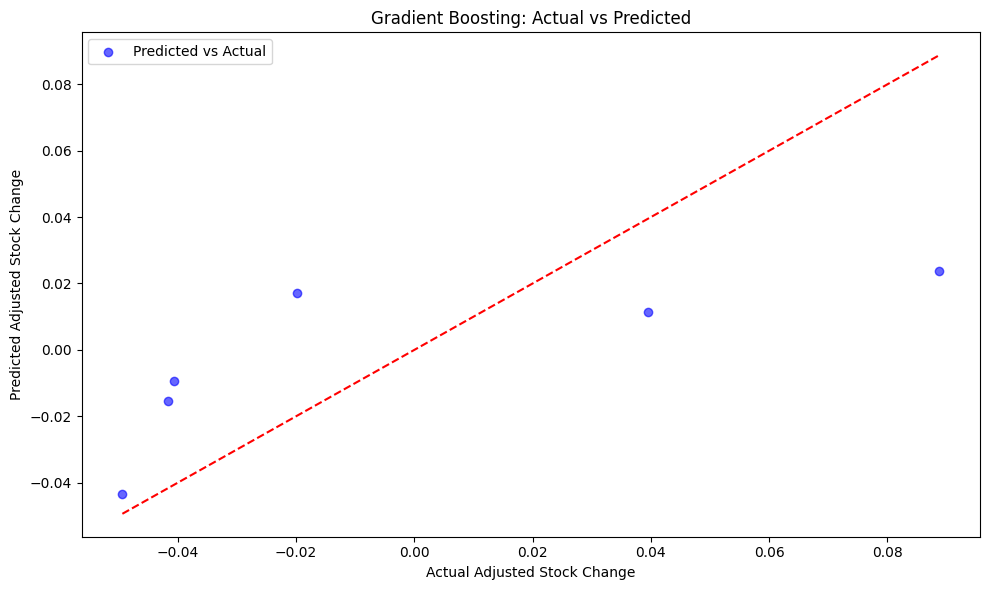

In [121]:
# Gradient Boosting Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Adjusted Stock Change")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("Gradient Boosting: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

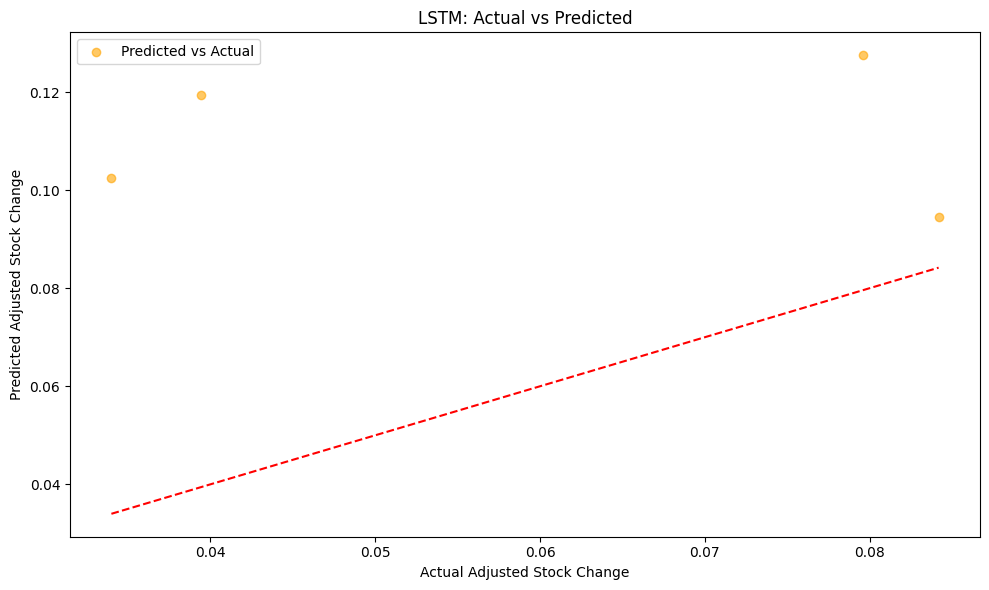

In [122]:
# LSTM Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, color="orange", label="Predicted vs Actual")
plt.plot([y_test_lstm.min(), y_test_lstm.max()], [y_test_lstm.min(), y_test_lstm.max()], color="red", linestyle="--")
plt.xlabel("Actual Adjusted Stock Change")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()


## Forecasting

Future scenarios of smoke impact are generated, and their economic implications are predicted using both models. This section provides stakeholders with actionable insights into potential future outcomes, assisting in planning and decision-making processes. Predictions are visualized to illustrate the projected trends and their implications.

#### New

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


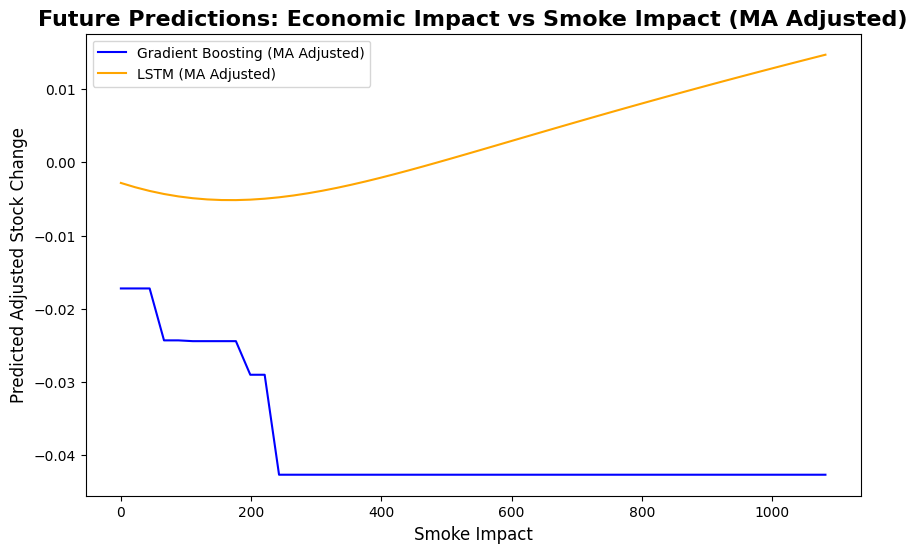

In [154]:
# Generate future smoke impact scenarios
future_smoke = np.linspace(merged_data["Smoke Impact"].min(), merged_data["Smoke Impact"].max(), 50).reshape(-1, 1)
future_features = np.hstack([future_smoke, np.zeros((50, len(features) - 1))])

# Scale features
future_features_scaled = scaler.transform(future_features)

# Predict using Gradient Boosting
future_pred_gb = gb_model.predict(future_features_scaled)

# Predict using LSTM
future_pred_lstm = lstm_model.predict(future_features_scaled[:, np.newaxis, :])

# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(future_smoke, future_pred_gb, label="Gradient Boosting (MA Adjusted)", color="blue")
plt.plot(future_smoke, future_pred_lstm, label="LSTM (MA Adjusted)", color="orange")
plt.xlabel("Smoke Impact", fontsize=12)
plt.ylabel("Predicted Adjusted Stock Change", fontsize=12)
plt.title("Future Predictions: Economic Impact vs Smoke Impact (MA Adjusted)", fontsize=16, weight="bold")
plt.legend()
plt.show()


## Predict Future Smoke Estimates (2025-2050), From Part 1 of the analysis 

In [124]:
# Prepare data for predictive model
X = smoke_data[["Year"]].values
y = smoke_data["Smoke Impact"].values

In [125]:
# Train a simple linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [126]:
# Forecast for the years 2025-2050
future_years = np.array(range(2025, 2051)).reshape(-1, 1)
predicted_smoke = model.predict(future_years)

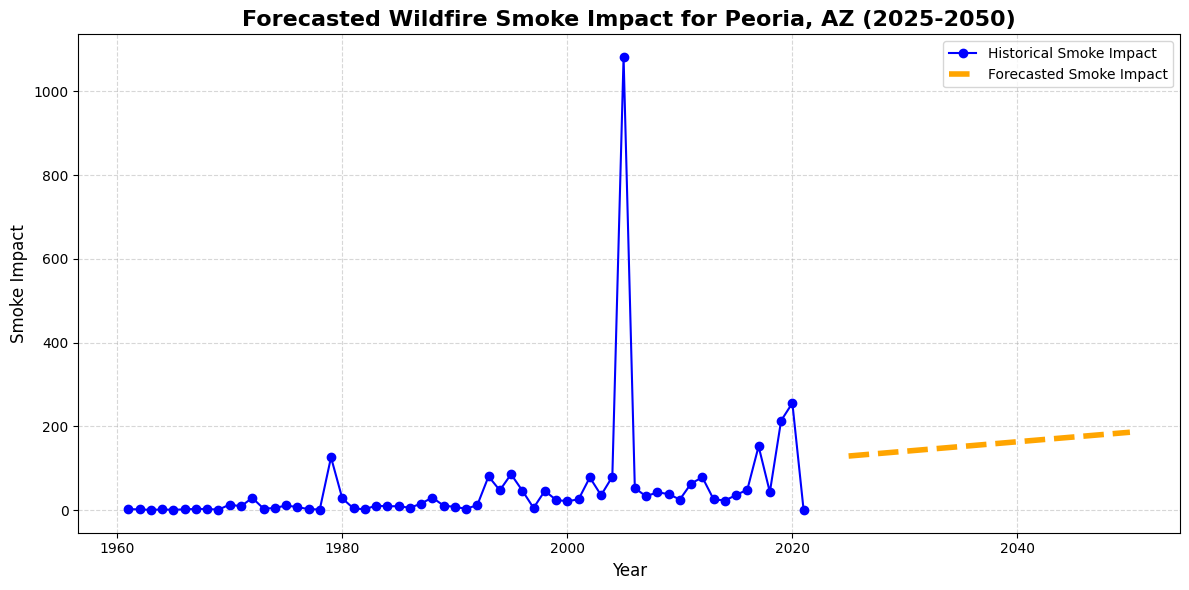

In [158]:
plt.figure(figsize=(12, 6))
plt.plot(
    smoke_data["Year"], 
    smoke_data["Smoke Impact"], 
    label="Historical Smoke Impact", marker="o", color="blue"
)
plt.plot(
    future_years.flatten(), 
    predicted_smoke, 
    label="Forecasted Smoke Impact", linestyle="--", color="orange", linewidth = 4
)
plt.title("Forecasted Wildfire Smoke Impact for Peoria, AZ (2025-2050)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Smoke Impact", fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


This forecast chart shows projected wildfire smoke impacts in Peoria from 2025 to 2050 (dashed orange line), based on historical trends which are also shown in the figure (solid blue line).

**Axes**: The x-axis represents years with historical data and future years with forecasted data, as it spans years from 1961 to 2050, and the y-axis shows the historical and predicted smoke impact values.

**How to Read**: Try and observe the projected trajectory and any upward or downward trends, helping to visualize potential future wildfire impacts. Dashed lines may indicate uncertainty, emphasizing that these predictions are based on past data trends and could vary.

**Underlying Data and Processing**: A linear regression model was used to predict future smoke impact, based on the historical smoke impact estimates from 1961 to 2021.

### Forecasted Wildfire Smoke Impact and Economic Impact (2025-2050)

Below are two visualizations portraying the same content. One with a focus on just the future projections and the other with a an understanding of the smoke impact histoircally in the region in addtion to the overlaid projections.

C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


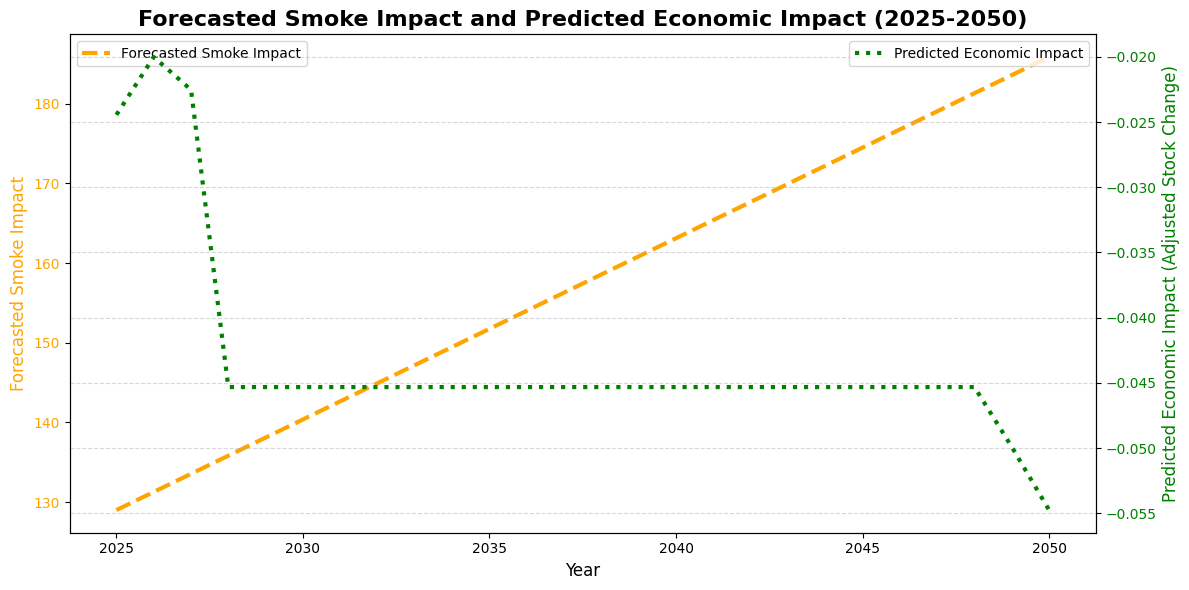

In [142]:
# Create lagged Smoke Impact features
future_features = np.zeros((len(predicted_smoke), len(features)))
future_features[:, 0] = predicted_smoke  # Set the Smoke Impact feature

# Fill in lagged Smoke Impact features
for lag in range(1, 4):  # Smoke Impact Lag 1 to Lag 3
    future_features[lag:, lag] = predicted_smoke[:-lag]

# Assume Adjusted Stock Change lags are zero (no prior predictions available)
# This simplifies future forecasting but might introduce some approximation errors.
for lag in range(4, 6):  # Adjusted Stock Change Lag 1 and Lag 2
    future_features[:, lag] = 0

# Scale features
future_features_scaled = scaler.transform(future_features)

# Predict using Gradient Boosting
future_adjusted_stock_change = gb_model.predict(future_features_scaled)

# Dual-axis plot for forecasted smoke impact and economic impact
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot forecasted smoke impact on the primary y-axis
color = "orange"
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Forecasted Smoke Impact", color=color, fontsize=12)
ax1.plot(
    future_years.flatten(),
    predicted_smoke,
    label="Forecasted Smoke Impact",
    linestyle="--",
    color=color,
    linewidth=3
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left", fontsize=10)

# Plot predicted economic impact on the secondary y-axis
ax2 = ax1.twinx()
color = "green"
ax2.set_ylabel("Predicted Economic Impact (Adjusted Stock Change)", color=color, fontsize=12)
ax2.plot(
    future_years.flatten(),
    future_adjusted_stock_change,
    label="Predicted Economic Impact",
    linestyle=":",
    color=color,
    linewidth=3
)
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right", fontsize=10)

# Title and grid
plt.title("Forecasted Smoke Impact and Predicted Economic Impact (2025-2050)", fontsize=16, weight="bold")
plt.grid(visible=True, linestyle="--", alpha=0.5)
fig.tight_layout()

# Show the plot
plt.show()


This forecast explores potential future wildfire smoke impacts and their predicted influence on stock performance in Peoria, AZ.

**Axes**:

- **Primary Y-axis (left)**: Forecasted Smoke Impact.
- **Secondary Y-axis (right)**: Predicted Adjusted Stock Change.
- **X-axis**: Year (2025-2050).

**How to Read**:

- Observe projected trends in smoke impact and their corresponding economic effects.
- Pay attention to predicted economic resilience or decline during periods of high forecasted smoke impact.

**Underlying Data and Processing**:

- Future smoke impact is predicted using a linear regression model trained on historical data.
- Adjusted stock change is forecasted using the Gradient Boosting model, with smoke impact features lagged by up to three years.

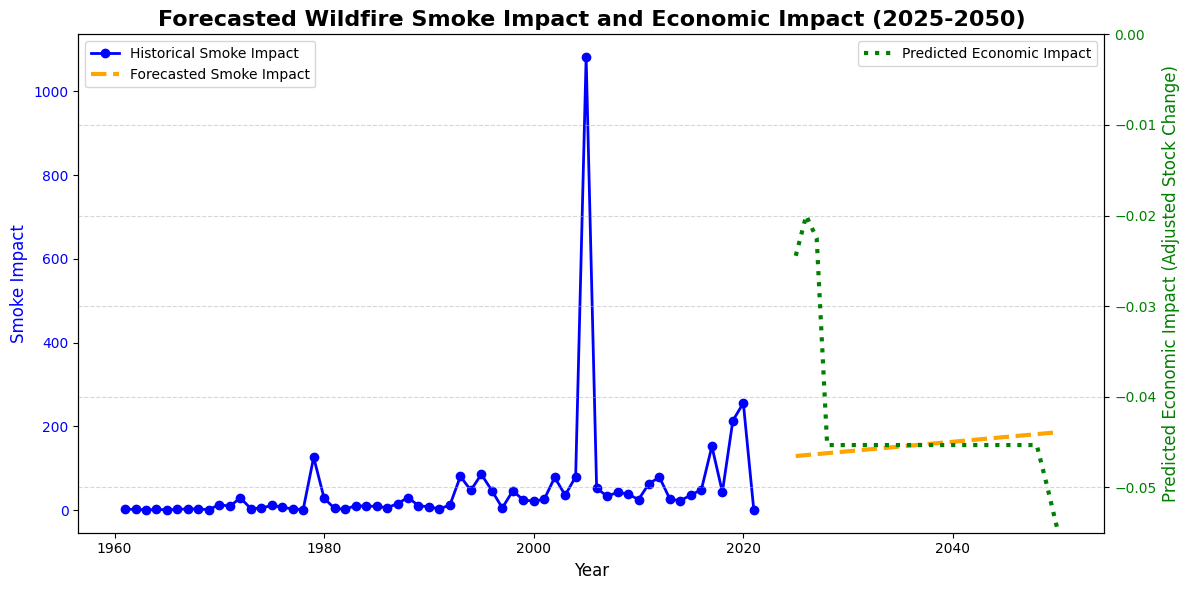

In [156]:
# Dual-axis plot for forecasted smoke impact and predicted economic impact
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot historical smoke impact on the primary y-axis
color = "blue"
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Smoke Impact", color=color, fontsize=12)
ax1.plot(
    smoke_data["Year"],
    smoke_data["Smoke Impact"],
    label="Historical Smoke Impact",
    marker="o",
    color=color,
    linewidth=2
)
ax1.plot(
    future_years.flatten(),
    predicted_smoke,
    label="Forecasted Smoke Impact",
    linestyle="--",
    color="orange",
    linewidth=3
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left", fontsize=10)

# Plot predicted economic impact on the secondary y-axis
ax2 = ax1.twinx()
color = "green"
ax2.set_ylabel("Predicted Economic Impact (Adjusted Stock Change)", color=color, fontsize=12)
ax2.plot(
    future_years.flatten(),
    future_adjusted_stock_change,
    label="Predicted Economic Impact",
    linestyle=":",
    color=color,
    linewidth=3
)
ax2.set_ylim(ymin = -0.055, ymax=0)
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right", fontsize=10)

# Enhance visualization
plt.title("Forecasted Wildfire Smoke Impact and Economic Impact (2025-2050)", fontsize=16, weight="bold")
plt.grid(visible=True, linestyle="--", alpha=0.5)
fig.tight_layout()

# Show the plot
plt.show()



This plot is displays similar information to the one above as this forecast explores potential future wildfire smoke impacts and their predicted influence on stock performance in Peoria, AZ. It also includes the historical smoke impact in the city. 

**Axes**:

- **Primary Y-axis (left)**: Smoke Impact. Along with the forecast for future smoke impact (Orange Line)
- **Secondary Y-axis (right)**: Predicted Adjusted Stock Change.
- **X-axis**: Year (2025-2050).

**How to Read**:

- Observe projected trends in smoke impact and their corresponding economic effects.
- Pay attention to predicted economic resilience or decline during periods of high forecasted smoke impact.

**Underlying Data and Processing**:

- Future smoke impact is predicted using a linear regression model trained on historical data.
- Adjusted stock change is forecasted using the Gradient Boosting model, with smoke impact features lagged by up to three years.


# Archive

#### Old

In [ ]:
# Lagged features for time series prediction
for lag in range(1, 4):
    merged_data[f"Smoke Impact Lag {lag}"] = merged_data["Smoke Impact"].shift(lag)
    merged_data[f"Adjusted Stock Change Lag {lag}"] = merged_data["Adjusted Stock Change"].shift(lag)

merged_data.dropna(inplace=True)

# Features and target
features = [
    "Smoke Impact", "Smoke Impact Lag 1", "Smoke Impact Lag 2", "Smoke Impact Lag 3",
    "Adjusted Stock Change Lag 1", "Adjusted Stock Change Lag 2"
]
target = "Adjusted Stock Change"

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data[features])
y = merged_data[target]


#### Old

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Grid search for Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best model
best_gb_model = grid_search.best_estimator_

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [ ]:
# Evaluate the model
y_pred = best_gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Optimized Gradient Boosting Model - MSE: {mse:.4f}, R²: {r2:.4f}")

ValueError: X has 6 features, but GradientBoostingRegressor is expecting 7 features as input.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Adjust sequence length
sequence_length = 10
X_lstm, y_lstm = [], []
for i in range(sequence_length, len(X)):
    X_lstm.append(X[i-sequence_length:i])
    y_lstm.append(y.iloc[i])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Train-test split
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm),
               callbacks=[early_stopping])

# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"Adjusted LSTM Model - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}")


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

#### Old

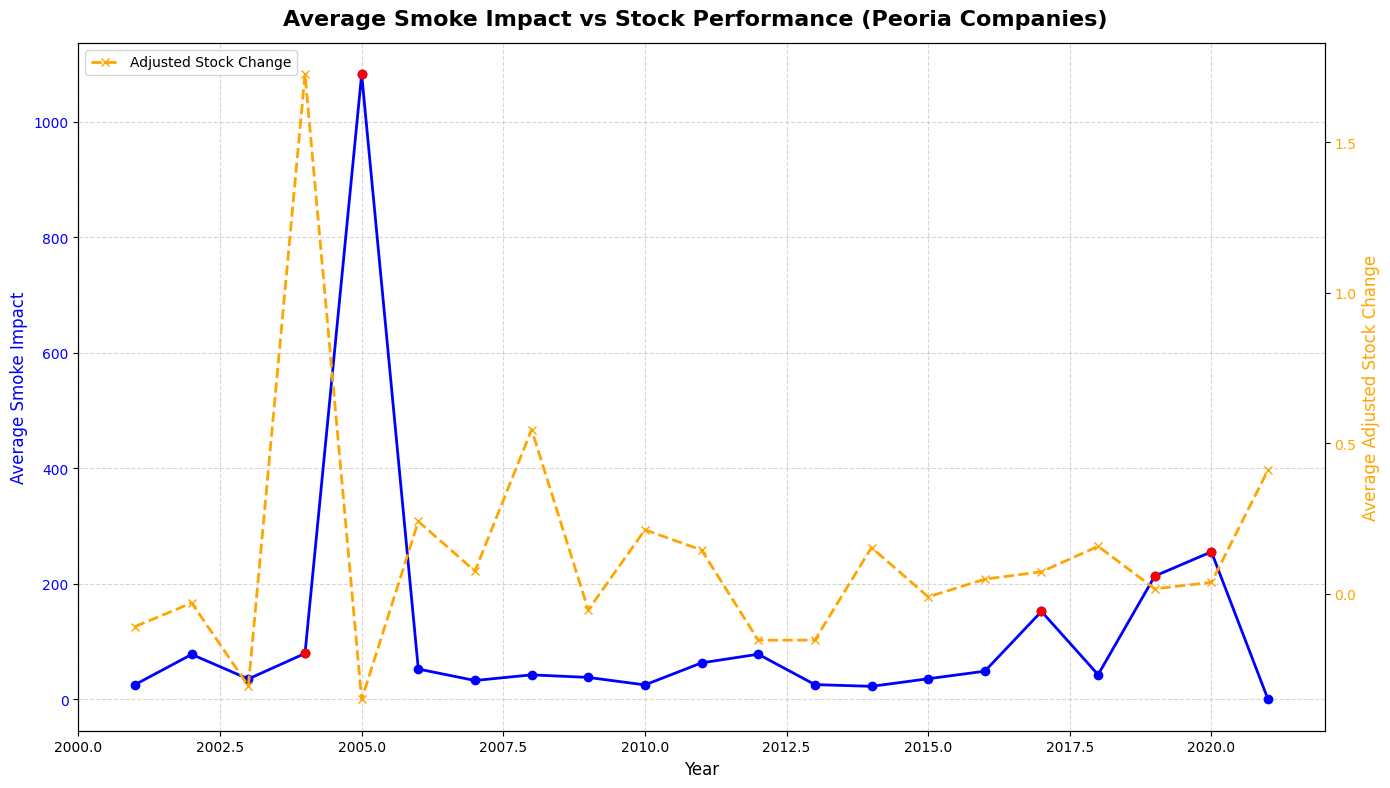

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Smoke Impact
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Average Smoke Impact", color="blue", fontsize=12)
ax1.plot(
    aggregated_data["Year"], 
    aggregated_data["Smoke Impact"], 
    marker="o", color="blue", label="Average Smoke Impact", linewidth=2
)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(visible=True, linestyle="--", alpha=0.5)

# Stock Performance
ax2 = ax1.twinx()
ax2.set_ylabel("Average Adjusted Stock Change", color="orange", fontsize=12)
ax2.plot(
    aggregated_data["Year"], 
    aggregated_data["Adjusted Stock Change"], 
    marker="x", color="orange", label="Adjusted Stock Change", linewidth=2, linestyle="--"
)
ax2.tick_params(axis="y", labelcolor="orange")

# Highlight high smoke impact years
high_impact_years = aggregated_data[aggregated_data["Smoke Impact"] > aggregated_data["Smoke Impact"].quantile(0.75)]
ax1.scatter(
    high_impact_years["Year"], 
    high_impact_years["Smoke Impact"], 
    color="red", zorder=5, label="High Impact Years"
)

# Title and legend
fig.suptitle("Average Smoke Impact vs Stock Performance (Peoria Companies)", fontsize=16, weight="bold")
fig.tight_layout()
plt.legend(fontsize=10, loc="upper left")
plt.show()


In [ ]:
# Generate future smoke impact scenarios
future_smoke = np.linspace(merged_data["Smoke Impact"].min(), merged_data["Smoke Impact"].max(), 50).reshape(-1, 1)
future_sp500 = np.zeros_like(future_smoke)
future_features = np.hstack([future_smoke, future_sp500, np.zeros((50, len(features) - 2))])

# Scale features
future_features_scaled = scaler.transform(future_features)

C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Predict using Gradient Boosting
future_pred_gb = gb_model.predict(future_features_scaled)


In [ ]:
# Predict using LSTM
future_pred_lstm = lstm_model.predict(future_features_scaled[:, np.newaxis, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 


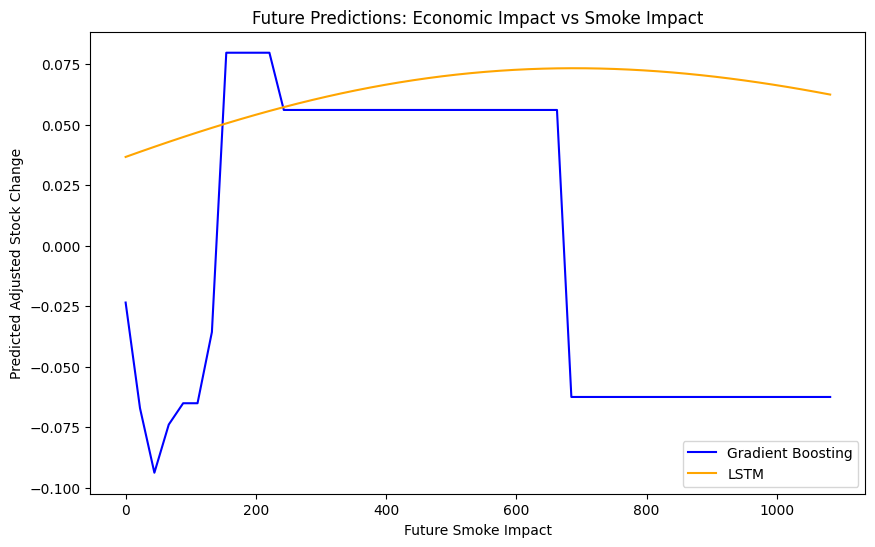

In [ ]:
# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(future_smoke, future_pred_gb, label="Gradient Boosting", color="blue")
plt.plot(future_smoke, future_pred_lstm, label="LSTM", color="orange")
plt.xlabel("Future Smoke Impact")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("Future Predictions: Economic Impact vs Smoke Impact")
plt.legend()
